# Data Preprocessing and Data Loading



The dataset that we chose consists of 20k reviews regarding hotel reviews from Tripadvisor. It is presented in a .csv file containing two columns: 

    Review: contains a review associated to an hotel. It is a string.
    Rating: contains a label indicating the rating assciated to an hotel. The different labels are {1,2,3,4,5}.

Some modifications of the dataset will be needed as well as some NLP techniques which will be useful to agilize the study and reduce the amount of nodes that will be present in our network. At this stage, our aim is to collect and create meaningful  data from the dataset. As we advance through the notebook, we will explain in more detail what we do.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


#### We read our .csv file:

In [11]:
df = pd.read_csv('tripadvisor_hotel_reviews.csv')
df

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1


#### Next, we will create an histogram to check how many reviews are associated with the different ratings labels:

array([[<AxesSubplot:title={'center':'Rating'}>]], dtype=object)

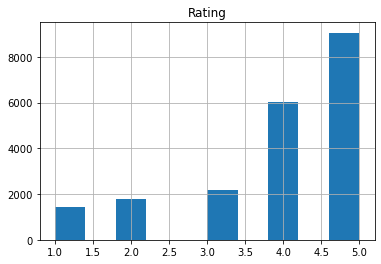

In [12]:
df.hist(column='Rating')

Observe that the ratings are pretty unbalanced as most of the reviews have a label of 4 or 5. As we intend to create a mode able to predict a rating and a sentiment from a review, it would be nice to have a better distribution of the ratings among the reviews. Otherwise, training a model with such an unbalanced data could result in a biased model.

There are different approaches to solve this issue:

    A. One of them could consist in randomly select around 2k reviews labeled with 5 and around 2k reviews labeled with 4. Our model would inmediately stop being unbalanced.
    
    B. The other approach would just consist in just dropping the reviews labeled with 5. Then, group the reviews labeled with 1,2 and 3 and relabel them as bringing a negative sentiment (0) and relabel the reviews labeled with 4 as bringing a positive sentiment (1). This would assure a balanced model for the sentiment training.
   

#### We will choose the approach B.

In [13]:
five_star_ratings_index = df.index[df['Rating']==5].tolist() #select rows labeled with 5

df = df.drop(index=five_star_ratings_index) #drop the rows that we selected
df = df.reset_index()
df = df.drop(columns=['index'])

NUMBER_OF_ROWS = df.shape[0]

df

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"excellent staff, housekeeping quality hotel ch...",4
4,"poor value stayed monaco seattle july, nice ho...",2
...,...,...
11432,not impressed unfriendly staff checked asked h...,2
11433,great location price view hotel great quick pl...,4
11434,"ok just looks nice modern outside, desk staff ...",2
11435,hotel theft ruined vacation hotel opened sept ...,1


#### We add a sentiment column to our modified dataframe accordingly to the approach B

In [14]:
df_sentiment = pd.DataFrame(data = np.zeros(NUMBER_OF_ROWS), columns=['Sentiment'],dtype='int64') #we create the sentiment column
df_model = pd.concat([df,df_sentiment], axis = 1)

for i in range(NUMBER_OF_ROWS): #we update the sentiment column
  if df_model.at[i,'Rating']==4:
    df_model.at[i,'Sentiment']=1
    
df_model

,Review,Rating,Sentiment
0,nice hotel expensive parking got good deal sta...,4,1
1,ok nothing special charge diamond member hilto...,2,0
2,nice rooms not 4* experience hotel monaco seat...,3,0
3,"excellent staff, housekeeping quality hotel ch...",4,1
4,"poor value stayed monaco seattle july, nice ho...",2,0
...,...,...,...
11432,not impressed unfriendly staff checked asked h...,2,0
11433,great location price view hotel great quick pl...,4,1
11434,"ok just looks nice modern outside, desk staff ...",2,0
11435,hotel theft ruined vacation hotel opened sept ...,1,0


#### We create a histogram on sentiment

We can now observe that we have fitted a pretty balanced model for the sentiment training at this stage. So we have a not biased model! It will be a good model with enough instances of both types 0 and 1 for training!

array([[<AxesSubplot:title={'center':'Sentiment'}>]], dtype=object)

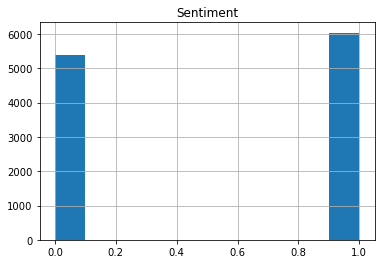

In [15]:
df_model.hist(column='Sentiment')

#### We look for null or na values among our data frame

We don't find any of these values, which shows the correctness of our data so far!

In [22]:
df_model.isnull().any().any().sum() #no null values

0

In [20]:
df_model.isna().sum() #no na values

Review       0
Rating       0
Sentiment    0
dtype: int64

In [21]:
(df_model['Review']=='').sum() #no blank review

0

## We will visualize a bit differently what's inside the data: Pie charts

---



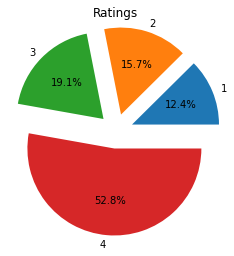

In [25]:
rating_counts = df_model['Rating'].value_counts()
size=[rating_counts.get(1), rating_counts.get(2),rating_counts.get(3), rating_counts.get(4)]
plt.pie(size, labels=['1','2','3','4'], autopct='%1.1f%%', explode=[0.2,0.2,0.2,0.2])
plt.title('Ratings')
plt.show()

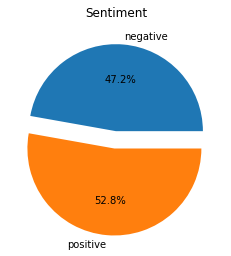

In [26]:
sentiment_counts = df_model['Sentiment'].value_counts()
size=[sentiment_counts.get(0), sentiment_counts.get(1)]
plt.pie(size, labels=['negative', 'positive'], autopct='%1.1f%%', explode=[0,0.2])
plt.title('Sentiment')
plt.show()

# Natural Language processing

## Text pre-processing

We will construct our network consisting of words acting as nodes. The conditions on the edges joining two nodes will be specified later on. 

Therefore, as a starting point we need to identify each review with the words that it contains. This will be achieved by splitting the original string (review) into smaller elements (words) separated by a blank character (' '). As a consequence, we will obtain a list of the words contained in the review. This process is called tokenization and it is a key point in the start of any NLP analysis.

For this, we will use the NLTK library. The method word_tokenize splits a string into alphanumeric values separated by a blank character and punctuation symbols with no need for them to be separated by a blank space.

##### An example of tokenization:

In [29]:
msg = 'We are creating a nice and interesting project. I hope we can obtain a good mark'

word_tokenize(msg.lower())

['we',
 'are',
 'creating',
 'a',
 'nice',
 'and',
 'interesting',
 'project',
 '.',
 'i',
 'hope',
 'we',
 'can',
 'obtain',
 'a',
 'good',
 'mark']

##### Deleting stopwords and punctuation symbols

The next step will be to delete meaningless items who came out of tokenization. We will delete punctuation symbols as well as the so called stopwords. 

Stopwords are those words which do not really provide any relevant information in a message since they are too much present in a language, so including them both in the network and in the training of the model will not bring any improvements nor understanding since they are not really characteristic words of a given sentiment or rating. We do not wish to have such words acting as nodes in our network as they will not bring any meaning and, probably they will induce a more complex network. Those can be words as for example: I, you, and, we, but...

The same happens for punctuation symbols, we do not want any punctuation symbol to play the role of a node in the network nor to train the model.

In [31]:
#Download the lists of stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Victor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

###### An example of 10 english stopwords :

In [32]:
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

##### An example of tokenization + deleting stopwords + removing punctuation:

In this example we can already see the effects of our method. We can extract the same understanding out of the clean tokenized message as from the original messsage. This is the kind of meaningful information that we refer to. We delete unnecesary elements with no need to loose meaningless out of a message.


This is the kind of direct data that we would like to have in our network and that will be useful to train our models.

In [36]:
#Delete stopwords
msg = 'We are creating a nice and interesting project. I hope we can obtain a good mark'

words = word_tokenize(msg.lower())
stop_words = set(stopwords.words('english'))

filtered_words = []
for word in words:
    if word not in stop_words and word.isalpha():
        filtered_words.append(word)
        
print(filtered_words)

['creating', 'nice', 'interesting', 'project', 'hope', 'obtain', 'good', 'mark']


### Stemming

A last preprocessing step on the body of every review must be that of stemming. Stemming may refer to reduce a word to its root. This step is indeed very useful and necessary to our purposes. Let us illustrate it with an example:

Imagine we have constructed our network and some of the nodes of our network are: interesting, interest, interested. Then:

    1. It is not computationally efficient to have different nodes assigned to words that provide us with the same meaning.
    
    2. This scenario may increase the complexity of our network.
    
    3. Training a model can be much harder and the resulting model may be way less accurate.
    
The solution is to have a common word (a stem) representing all its variants. In the example: 'interest' would be the stem and therefore 'interest' should be the node appearing in the network representing all of its variants.

There are different stemming algorithms. We will use the Snowball Stemmer as it is not very aggresive on the stemming and we will still need to extract understanding out of the network that we will construct.

In [38]:
#Delete stopwords + Stemming + Remove punctuation:

mag = 'We are creating a nice and interesting project. I hope we can obtain a good mark'

words = word_tokenize(mag.lower())
stop_words = set(stopwords.words('english'))

stemmer = SnowballStemmer('english')

filtered_words = []
for word in words:
    if word not in stop_words and word.isalpha(): #(isalphabet)
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
        
print(filtered_words)

['creat', 'nice', 'interest', 'project', 'hope', 'obtain', 'good', 'mark']


#### Let us convert all the steps that we took into a function that can be applied to every review of our data frame

In [40]:
def clean_review(review, stemmer = SnowballStemmer('english'), stop_words = set(stopwords.words('english'))):

  words = word_tokenize(review.lower())
  
  filtered_words = []
  for word in words:
      if word not in stop_words and word.isalpha(): #(isalphabet)
          stemmed_word = stemmer.stem(word)
          filtered_words.append(stemmed_word)
  return filtered_words

In [41]:
#An example
clean_review('This is a really nice and interesting project. What do you think?')

['realli', 'nice', 'interest', 'project', 'think']

## Tokenizing and cleaning every review of the data frame

In [77]:
stemmed_nested_list = df_model.Review.apply(clean_review)
print(stemmed_nested_list)

0        [nice, hotel, expens, park, got, good, deal, s...
1        [ok, noth, special, charg, diamond, member, hi...
2        [nice, room, experi, hotel, monaco, seattl, go...
3        [excel, staff, housekeep, qualiti, hotel, choc...
4        [poor, valu, stay, monaco, seattl, juli, nice,...
                               ...                        
11432    [impress, unfriend, staff, check, ask, higher,...
11433    [great, locat, price, view, hotel, great, quic...
11434    [ok, look, nice, modern, outsid, desk, staff, ...
11435    [hotel, theft, ruin, vacat, hotel, open, sept,...
11436    [peopl, talk, ca, believ, excel, rate, hotel, ...
Name: Review, Length: 11437, dtype: object


Next, we would like that regardless of the total times that a stem appears such  stem constitutes just one single node in the network. For that we collect the unique words (stems)

In [78]:
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]
unique_words = pd.Series(flat_stemmed_list).value_counts()
NUMBER_OF_UNIQUE_WORDS = len(unique_words)

print('Number of unique words:',len(unique_words), '\n')

print('The next output shows the different unique words (stems) and the total number of corresponding apparitions:')

unique_words

Number of unique words: 25661 

The next output shows the different unique words (stems) and the total number of corresponding apparitions:


room            29485
hotel           29175
stay            15383
good            11338
great           10489
                ...  
loiung              1
surplus             1
bordeoux            1
restaurantsw        1
barcelonin          1
Length: 25661, dtype: int64

### Creation of a vocabulary

We will associate an unique ID to every unique word (stem). We will follow the next logic: the lower the ID of a word is, the more frequently the word appears. E.g, the ID of room would be 0 since is the most frequent word. The Id of hotel would be 1, and so on... This logic will also provide us with a good understanding during the study of the network as it will offer some good functionalities.

In [79]:
dictionary = {}

for i in range(NUMBER_OF_UNIQUE_WORDS):
  dictionary[unique_words.index[i]]=i

Next, we convert every word in each stemmed list corresponding to every review into its word ID. In this sense, the information contained in every stemmed list of words will be represented as a list of the corresponding words ID's

In [80]:
#We convert the words in the stemmed lists to its corresponding word ID's

stemmed_nested_list = stemmed_nested_list.tolist()
stemmed_nested_list_IDs = []

for sublist in stemmed_nested_list:
  sublist_ID=[]
  for element in sublist:
    sublist_ID.append(dictionary[element])
  stemmed_nested_list_IDs.append(sublist_ID)



print('An example: The first review would be represented as follows')

stemmed_nested_list_IDs[0]

An example: The first review would be represented as follows


[7,
 1,
 163,
 86,
 28,
 3,
 192,
 2,
 1,
 1074,
 53,
 209,
 185,
 110,
 727,
 377,
 50,
 630,
 86,
 42,
 250,
 190,
 32,
 146,
 46,
 0,
 0,
 12,
 7,
 150,
 22,
 69,
 1508,
 3683,
 3384,
 132,
 415,
 1852,
 14,
 421,
 406,
 0,
 5,
 87,
 401,
 1338,
 79,
 92,
 73,
 299,
 24,
 403,
 656,
 381,
 289,
 1397,
 2810,
 314,
 1293,
 7,
 5286,
 2,
 7,
 497,
 452,
 945,
 2,
 795,
 9,
 4,
 18,
 244,
 84,
 127,
 7,
 95,
 104,
 86,
 5]

### Creation of the data frames for the construction of the network and the training of the models

This next data frame will consist of 11437 rows each of which corresponding to a review and 25660 columns each of which corresponding to a unique word ID.

The data frame will be filled following the next logic:

    -The entry [i,j] will be marked as 1 if the word with ID equal to j is present in the review i.
    
    -The entry [i,j] will be marked as 0 if the word with ID equal to j is NOT present in the review i.
    
Notice how entries corresponding to first columns are usually marked with 1's and entries corresponding to last columns are marked with 0's. This is due to how we constructed our vocabulary and the corresponding ID's. We recall that the more frequently a word appears, the lower the ID is. This results very convenient since if we intend to do some reduction of the data frame we can just drop the n-th last columns without assuming the risk of loosing very meaningful data.

In [82]:
NUMBER_OF_ROWS = NUMBER_OF_ROWS #number of reviews
NUMBER_OF_COLS = NUMBER_OF_UNIQUE_WORDS #number of unique words

df_words = pd.DataFrame(np.zeros((NUMBER_OF_ROWS, NUMBER_OF_COLS)),dtype ='int64')

row = 0
for lista in stemmed_nested_list_IDs:
  for elemento in lista:
    df_words.at[row,elemento] =1
  row+=1

df_words #notice how most popular words appear usually

,0,1,2,3,4,5,6,7,8,9,...,25651,25652,25653,25654,25655,25656,25657,25658,25659,25660
0,1,1,1,1,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,1,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11432,1,1,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11433,0,1,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
11434,1,1,0,1,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
11435,1,1,1,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,1


In [39]:
#Next we will construct our data frames for ML. For sentiment and rating prediction respectively

In [40]:
df_model_sentiment = pd.concat([df_model.loc[:,['Sentiment']],df_words], axis = 1)
df_model_sentiment

,Sentiment,0,1,2,3,4,5,6,7,8,...,25651,25652,25653,25654,25655,25656,25657,25658,25659,25660
0,1,1,1,1,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0,1,1,1,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11432,0,1,1,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
11433,1,0,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
11434,0,1,1,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
11435,0,1,1,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,1


In [41]:
df_model_sentiment_large = df_model_sentiment.sample(n=10000, axis=0)
df_model_sentiment_large = df_model_sentiment_large.iloc[:, :5000]


df_model_sentiment_large.to_csv('sentiment_large.csv', encoding = 'utf-8-sig')

In [54]:
df_model_sentiment_reduced = df_model_sentiment.sample(n=3000, axis=0)
df_model_sentiment_reduced = df_model_sentiment_reduced.iloc[:, :1000]

In [ ]:


#df_model_sentiment_reduced.to_csv('sentiment_reduced.csv', encoding = 'utf-8-sig')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [39]:
df_model_rating = pd.concat([df_model.loc[:,['Rating']],df_words], axis = 1)
df_model_rating

,Rating,0,1,2,3,4,5,6,7,8,...,25651,25652,25653,25654,25655,25656,25657,25658,25659,25660
0,4,1,1,1,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,1,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,1,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,1,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11432,2,1,1,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
11433,4,0,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
11434,2,1,1,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
11435,1,1,1,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,1


In [40]:
df_model_rating_large = df_model_rating.sample(n=10000, axis=0)
df_model_rating_large = df_model_rating_large.iloc[:, :5000]


#df_model_rating_large.to_csv('rating_large.csv', encoding = 'utf-8-sig')

In [56]:
df_model_rating_reduced = df_model_rating.sample(n=3000, axis=0)
df_model_rating_reduced = df_model_rating_reduced.iloc[:, :1000]

In [57]:
df_model_rating_reduced

,Rating,0,1,2,3,4,5,6,7,8,...,989,990,991,992,993,994,995,996,997,998
21,1,1,1,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7198,1,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1097,4,0,1,1,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3671,2,1,1,1,1,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
6930,4,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11140,1,1,1,1,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
9597,2,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1419,4,1,1,1,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2762,1,1,1,1,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0


In [ ]:


#df_model_rating_reduced.to_csv('rating_reduced.csv', encoding = 'utf-8-sig') 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Split for training and testing**

In [ ]:
X = df_model_rating_reduced.drop(['Rating'], axis = 1)
y = df_model_rating_reduced['Rating']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 26)

In [ ]:
from sklearn.linear_model import LogisticRegression

# Create instance of model
lreg = LogisticRegression()
# Pass training data into model
lreg.fit(x_train, y_train)

In [ ]:
# Confusion Matrix
print('Logistic Regression')
print('\n')
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_lreg))
print('--'*50)

# Classification Report
print('Classification Report')
print(classification_report(y_test,y_pred_lreg))


# Accuracy of our model
print('--'*50)
logreg_accuracy = round(accuracy_score(y_test, y_pred_lreg) * 100,8)
print('Accuracy = ', logreg_accuracy,'%')

In [58]:
#Everything runs nice!